# Adventure Works Exploration

> The first thing we have to get familiar with is markdown syntax. Markdown is part of what makes the Jupyter Notebook magical. It allows us to annotate our progress as we analyze our data. Markdown text is formatted to allow for easy reading by the Notebook's audience. This very block of text was written using markdown. We are going to be using it throughout this document. To change a Jupyter Notebook cell into a markdown cell simply click on it, and then toggle the dropdown on the toolbar to "Markdown". For a guide on markdown syntax, take a look at this [documentation](https://www.markdownguide.org/cheat-sheet/).

> Also FYI, all instructions are going to be wrapped up in block quotes such as this one. When we are done with our tutorial, we are going to remove them so that the report is cleaner.

> The first thing we want to do is define our problem. Our imaginary colleague works in marketing and wants to get an idea of product and sales performance. Their request is vague, so it's up to us to turn it into a structured task we can work and deliver on. Let's do that using a **Problem Statement**. We will use the S.M.A.R.T framework for this.

## Problem Statement

Adventure Works Cycles is a [fictitious]  large, multinational manufacturing company that produces and distributes metal and composite bicycles to commercial markets in North America, Europe, and Asia. To enable the marketing team to enhance resource allocation and campaign design, we will perform a comprehensive analysis of product and sales performance. This will include identifying the top 10 most popular products, top 10 profitable products within each product category, analyzing sales trends over the past year, determining the sales location distribution, and creating a visualization dashboard to condense our findings.

**Context of the problem**:
Our marketing team needs a comprehensive analysis of product and sales performance, for the ecommerce wing og the business, to inform future marketing strategies and product promotions. The analysis should focus on identifying the most popular products, the most profitable products, and sales trends over time.

**Scope of the solution space**:
1. A list of the top 10 most popular products by sales volume (current year).
2. A list of the top 10 most profitable products within each product category (current year).
3. A sales trend analysis that shows monthly sales growth or decline over the past year by product category (current year).
4. Sales distribution by location (current year).

**Stakeholders**:
- Clara from marketing

**Data Sources**:
- Adventure Works Data Warehouse

**Link to project management tool**:
- [Trello, Jira, Notion, et al](https://www.example.com)

> Remember we are telling a story that we want an audience to follow, both technical and non-technical, so let's appropriately label our sections. We do this simply by using markdown to create headings. We've already done this above by providing a section heading for our **Problem Statement**. We will do it again below for our **Import Modules** section. We will continue using section headings throughout this document for easier readability.

> **NB**: If you want to know the markdown syntax for headings, take a look at the [documentation](https://www.markdownguide.org/cheat-sheet/)

## Import Modules

In [30]:
from __future__ import division

import warnings

warnings.filterwarnings("ignore") # we use this to ignore any warnings pandas/numpy might throw at us

from IPython.display import HTML, Image # we are going to use this to manipulate the notebook's behavior

from datetime import datetime, timedelta
from sqlalchemy import create_engine
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import pandas as pd

import requests

import plotly
import plotly.express as px
import plotly.io as pio

plotly.offline.init_notebook_mode(connected=True) # allows us to view our plotly visualizations when we export our notebook to html
pio.renderers.default = 'notebook'

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None) # we don't want pandas to limit the number of columns we can view
pd.options.display.float_format = '{:,.2f}'.format # we want our numerical data to be thousand comma separated, and floats to be rounded to 2dp

print("Successfully imported modules...")

Successfully imported modules...


## Connect to Data Source(s)

In [3]:
# let's create a function that return a sqlalchemy engine that we will use to connect to the data warehouse
def createDatawarehouseEngine():
    """
        Constructs a sqlalchemy  engine.
        Returns the engine.
    """
    engine = create_engine("mssql+pyodbc://localhost/AdventureWorksDW2019?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")
    return engine

# test out your engine
try:
    with createDatawarehouseEngine().connect() as connection:
        print("Connection to SQL Server using trusted connection successful...")
except Exception as e:
    print(f"Error connecting to SQL Server: {e}. Diagnose and fix your error before continuing...")

Connection to SQL Server using trusted connection successful...


## Explaratory Data Analysis

> Now let's analyze the objectives in our **Scope of the solution space**, one at a time

### 1. A list of the top 10 most popular products by sales volume (current year)

> We are going to be using the pandas *read_sql_query* method to directly load sql result sets into pandas dataframes. Very very handy.

In [4]:
# we will use a context manager (the with block) because we want our db connection to
# close automatically when we are done with it
with createDatawarehouseEngine().connect() as conn:
    df_prod = pd.read_sql_query("""
        SELECT TOP 10 dp.EnglishProductName, SUM(OrderQuantity) AS Quantity
        FROM FactInternetSales fis
        INNER JOIN DimProduct dp ON dp.ProductKey=fis.ProductKey
        WHERE OrderDate >= '2013-01-01 00:00:00.000'
        GROUP BY dp.EnglishProductName
        ORDER BY SUM(OrderQuantity) DESC;
    """, conn)

In [5]:
df_prod

,EnglishProductName,Quantity
0,Water Bottle - 30 oz.,4226
1,Patch Kit/8 Patches,3187
2,Mountain Tire Tube,3092
3,Road Tire Tube,2369
4,"Sport-100 Helmet, Red",2220
5,AWC Logo Cap,2182
6,Fender Set - Mountain,2116
7,"Sport-100 Helmet, Blue",2115
8,"Sport-100 Helmet, Black",2079
9,Mountain Bottle Cage,2014


> For our visualizations, we are going to use plotly.

In [31]:
fig = px.bar(df_prod, x='Quantity', y='EnglishProductName', orientation='h')
fig.update_layout(
    margin=dict(t=30,b=20,l=20,r=20),
    title="<b>Top 10 Products (current Year)</b>",
    title_x=0.5,
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=400,
    font=dict(
        family="Arial",
        size=10,
        color="black",
    ),
    yaxis=dict(autorange="reversed"),
    showlegend=False
)
fig.write_image("top-10-prod.png")

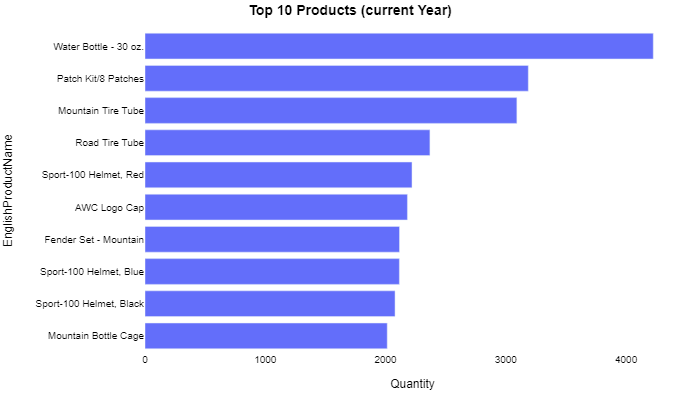

In [32]:
Image("top-10-prod.png")

**--INSIGHTS**
- the chart above shows us our top 10 popular products for the current year (2013)
- we can also see that the leading product is a _Water Bottle_.
- let's explore the water bottle's popularity a step further by asking the following questions:
    - is the water bottle's popularity seasonal or constant?
    - is the water bottle purchased separately or with other products?

**IS THE WATER BOTTLE'S POPULARITY SEASONAL OR CONSTANT?**

In [34]:
with createDatawarehouseEngine().connect() as conn:
    wb_time_series = pd.read_sql_query("""
        SELECT fis.OrderDate, fis.OrderQuantity AS Quantity
        FROM FactInternetSales fis
        INNER JOIN DimProduct dp ON dp.ProductKey=fis.ProductKey
        WHERE dp.EnglishProductName='Water Bottle - 30 oz.'
        ORDER BY fis.OrderDate;
    """, conn)

In [35]:
wb_time_series.set_index('OrderDate', inplace=True)
wb_time_series = wb_time_series.resample('M').sum()

fig = px.line(
    wb_time_series,
    y="Quantity",
)
fig.update_layout(
    margin=dict(t=30,b=20,l=20,r=20),
    title="<b>Water Bottle Time Series: all-time</b>",
    title_x=0.5,
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=400,
    font=dict(
        family="Arial",
        size=10,
        color="black",
    ),
    showlegend=True
)
fig.write_image("wb-time-series.png")

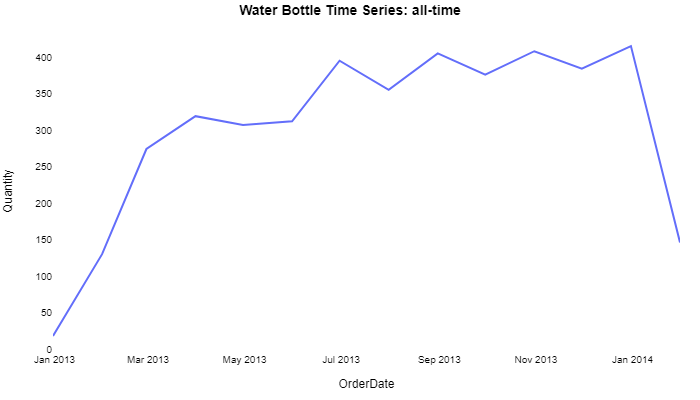

In [36]:
Image("wb-time-series.png")

**--INSIGHTS**
- there doesn't seem to be any fluctuations in the Water Bottle's demand, therefore we can safely say it isn't a seasonal product.
- since the water bottle's demand is constant, and we also know that it's an accessory in our store, it becomes a prime candidate for cross-selling, i.e, we can suggest it as an add-on when customers purchase other products.
- which leads us into our next question:

**IS THE WATER BOTTLE PURCHASED SEPARATELY OR WITH OTHER PRODUCTS?**

In [26]:
with createDatawarehouseEngine().connect() as conn:
    wb_basket_mix = pd.read_sql_query("""
        SELECT fis.SalesOrderNumber, dp.EnglishProductName, fis.OrderQuantity
        FROM FactInternetSales fis
        INNER JOIN DimProduct dp ON dp.ProductKey=fis.ProductKey
        WHERE fis.SalesOrderNumber IN (
            SELECT fis.SalesOrderNumber 
            FROM FactInternetSales fis
            INNER JOIN DimProduct dp ON dp.ProductKey=fis.ProductKey 
            WHERE dp.EnglishProductName='Water Bottle - 30 oz.'
        )
        ORDER BY fis.SalesOrderNumber;
    """, conn)
    print(f"Returned {len(wb_basket_mix)} rows...")

Returned 13791 rows...


> Our SQL query returned a number of rows, which tells us that there are instances where the Water Bottle is purchased along with other products. So we are going to carry on with market basket analysis.

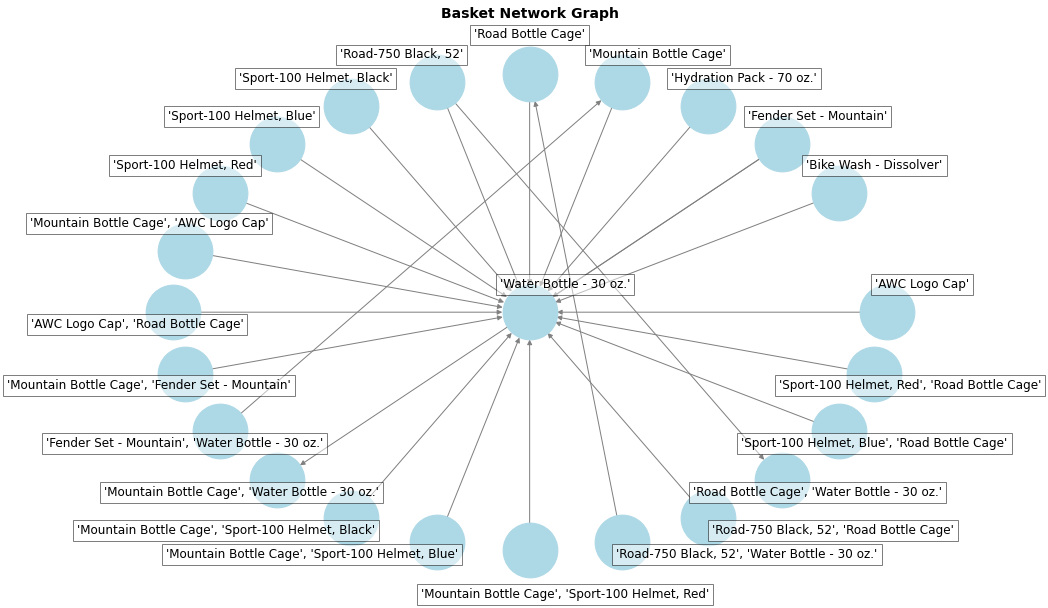

In [27]:
# group by the order number and product_name
wb_basket_mix = wb_basket_mix.groupby(['SalesOrderNumber', 'EnglishProductName'])['OrderQuantity']
# next, one hot encode the data to prepare for our machine algorithm - we are
# going to be using mlxtend
wb_basket_mix = wb_basket_mix.sum().unstack().reset_index().fillna(0).set_index('SalesOrderNumber')
# take care of any instances where a datapoint is greater than 1
def encode_data(datapoint):
    if datapoint <= 0:
        return 0
    if datapoint >= 1:
        return 1
wb_basket_mix = wb_basket_mix.applymap(encode_data)

# identify the basket mixes
itemsets = apriori(wb_basket_mix, min_support=0.03, use_colnames=True)
rules = association_rules(itemsets, metric="lift", min_threshold=0.5)

# we only want the rules where the Water Bottle is present, so let's filter by that
rules['filter_antecedents'] = rules.antecedents.astype(str)
rules['filter_consequents'] = rules.consequents.astype(str)
rules = rules.loc[(rules.filter_antecedents.str.contains('Water Bottle')) | (rules.filter_consequents.str.contains('Water Bottle'))]
rules.drop(columns=['filter_antecedents', 'filter_consequents'], inplace=True)
# let's also filter our rules by a confidence of 0.5 or greater
rules = rules.loc[rules.confidence>=0.5]

# transform antecedents and consequents to plain strings
rules.antecedents = rules.antecedents.apply(lambda x: str(list(x)).replace("[","").replace("]",""))
rules.consequents = rules.consequents.apply(lambda x: str(list(x)).replace("[","").replace("]",""))

# Initialize a directed graph
G = nx.DiGraph()

# Add edges and nodes
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'])

# Define node positions
pos = nx.circular_layout(G)

# Specify the center node
center_node = "'Water Bottle - 30 oz.'"
if center_node in pos:
    pos[center_node] = [0, 0]  # Place the center node at the origin

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')

# Draw edge labels with confidence
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Manual offset for node labels to avoid overlapping
for node, (x, y) in pos.items():
    offset_x = 0.1 if x >= 0 else -0.1
    offset_y = 0.1 if y >= 0 else -0.065
    if node=="'Road Bottle Cage'":
        offset_x=0
        offset_y=0.15
    if node=="'Mountain Bottle Cage', 'Sport-100 Helmet, Red'":
        offset_y=-0.2
    if node=="'Mountain Bottle Cage', 'Sport-100 Helmet, Blue'" or node=="'Mountain Bottle Cage', 'Sport-100 Helmet, Black'":
        offset_x=-0.35
    if node=="'Road-750 Black, 52', 'Road Bottle Cage'" or node=="'Road-750 Black, 52', 'Water Bottle - 30 oz.'":
        offset_x=0.35
    plt.text(x + offset_x, y + offset_y, s=node, bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center', fontsize=12)

plt.title('Basket Network Graph', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.show()

**--INSIGHTS**
- from the network graph above, we can ascertain that the _Water Bottle_ is purchased with other products, and from those associations, marketing can formulate a cross-selling strategy

### 2. A list of the top 10 most profitable products within each product category (current year).

In [14]:
with createDatawarehouseEngine().connect() as conn:
    df_profit_margin = pd.read_sql_query("""
        SELECT EnglishProductCategoryName, Row_Number, EnglishProductName, ProfitMargin
        FROM
        (SELECT dpc.EnglishProductCategoryName, dp.EnglishProductName, 
            ROW_NUMBER() OVER (PARTITION BY dpc.EnglishProductCategoryName ORDER BY (SUM(SalesAmount)-SUM(TotalProductCost)-SUM(TaxAmt)-SUM(Freight))/SUM(SalesAmount) DESC) AS Row_Number,
            (SUM(SalesAmount)-SUM(TotalProductCost)-SUM(TaxAmt)-SUM(Freight))/SUM(SalesAmount) AS ProfitMargin
        FROM FactInternetSales fis
        INNER JOIN DimProduct dp ON dp.ProductKey=fis.ProductKey
        INNER JOIN DimProductsubcategory dpsc ON dpsc.ProductSubcategoryKey=dp.ProductSubcategoryKey
        INNER JOIN DimProductCategory dpc ON dpc.ProductCategoryKey=dpsc.ProductCategoryKey
        WHERE OrderDate >= '2013-01-01 00:00:00.000'
        GROUP BY dpc.EnglishProductCategoryName, dp.EnglishProductName) q
        WHERE Row_Number <=10;
    """, conn)

In [15]:
df_profit_margin
df_profit_margin.style.format({
    'ProfitMargin': '{:,.2%}'.format
})

,EnglishProductCategoryName,Row_Number,EnglishProductName,ProfitMargin
0,Accessories,1,Hitch Rack - 4-Bike,52.10%
1,Accessories,2,HL Road Tire,52.10%
2,Accessories,3,Fender Set - Mountain,52.10%
3,Accessories,4,HL Mountain Tire,52.10%
4,Accessories,5,All-Purpose Bike Stand,52.10%
5,Accessories,6,Mountain Tire Tube,52.09%
6,Accessories,7,LL Road Tire,52.09%
7,Accessories,8,"Sport-100 Helmet, Blue",52.09%
8,Accessories,9,"Sport-100 Helmet, Red",52.09%
9,Accessories,10,ML Mountain Tire,52.09%


**--INSIGHTS**
- the top 10 products by profit margin indicate to us that each product category applies a constant profit margin calculation to all the products within each category

### 3. A sales trend analysis that shows monthly sales growth or decline over the past year by product category

In [16]:
with createDatawarehouseEngine().connect() as conn:
    df_sales = pd.read_sql_query("""
        SELECT FORMAT(fis.OrderDate, 'MMM-yyyy') AS OrderDate, dpc.EnglishProductCategoryName, 
            SUM(fis.OrderQuantity) AS OrderQuantity, SUM(fis.SalesAmount) AS SalesAmount
        FROM FactInternetSales fis
        INNER JOIN DimProduct dp ON dp.ProductKey=fis.ProductKey
        INNER JOIN DimProductsubcategory dpsc ON dpsc.ProductSubcategoryKey=dp.ProductSubcategoryKey
        INNER JOIN DimProductCategory dpc ON dpc.ProductCategoryKey=dpsc.ProductCategoryKey
        WHERE fis.OrderDate >= '2013-01-01 00:00:00.000'
        GROUP BY FORMAT(fis.OrderDate, 'MMM-yyyy'), dpc.EnglishProductCategoryName
        ORDER BY FORMAT(fis.OrderDate, 'MMM-yyyy');
    """, conn)

> Bikes revenue is not comparable to Accessories and Clothing, so we are going to have to plot them separately

In [37]:
bikes_sales = df_sales.query("EnglishProductCategoryName=='Bikes'")

categories = [
    'Jan-2013', 'Feb-2013', 'Mar-2013', 'Apr-2013', 'May-2013', 'Jun-2013',
    'Jul-2013', 'Aug-2013', 'Sep-2013', 'Oct-2013', 'Nov-2013', 'Dec-2013'
]
bikes_sales.OrderDate = pd.Categorical(
    bikes_sales.OrderDate, 
    categories=categories,
    ordered=True
)
bikes_sales.sort_values('OrderDate', inplace=True)

fig = px.line(
    bikes_sales, 
    x="OrderDate", 
    y="SalesAmount", 
    color="EnglishProductCategoryName"
)
fig.update_layout(
    margin=dict(t=30,b=20,l=20,r=20),
    title="<b>Sales Trend (Bikes): 2013-to-date</b>",
    title_x=0.5,
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=400,
    font=dict(
        family="Arial",
        size=10,
        color="black",
    ),
    showlegend=True
)
fig.write_image("st-bikes.png")

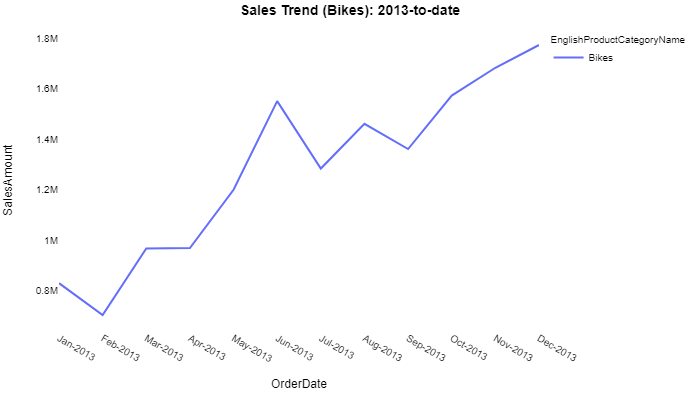

In [38]:
Image("st-bikes.png")

In [39]:
accessories_clothing_sales = df_sales.query("EnglishProductCategoryName!='Bikes'")

accessories_clothing_sales.OrderDate = pd.Categorical(
    accessories_clothing_sales.OrderDate, 
    categories=categories,
    ordered=True
)
accessories_clothing_sales.sort_values('OrderDate', inplace=True)

fig = px.line(
    accessories_clothing_sales, 
    x="OrderDate", 
    y="SalesAmount", 
    color="EnglishProductCategoryName"
)
fig.update_layout(
    margin=dict(t=30,b=20,l=20,r=20),
    title="<b>Sales Trend (Accessories & Clothing): 2013-to-date</b>",
    title_x=0.5,
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=400,
    font=dict(
        family="Arial",
        size=10,
        color="black",
    ),
    showlegend=True
)
fig.write_image("st-accessories-clothing.png")

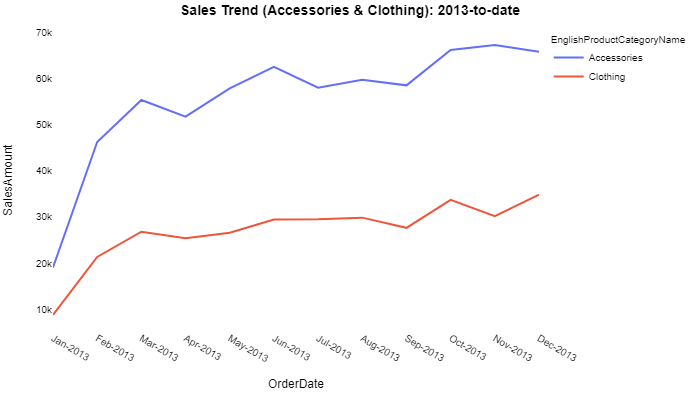

In [40]:
Image("st-accessories-clothing.png")

**--INSIGHTS**
- the Bikes category exhibits an upward trend that showed no signs of ceasing as the year went on
- Bikes is the primary category of the business, so this demonstrates growth. To ascertain that claim, a further financial analysis (financial statements) would have to be done, but that's outside the scope of this report
- Accessories and Clothing, however, exhibited muted growth through the year. In fact, it's almost flat
- these are the 2 categories that marketing should probably focus their campaign efforts on. We've already shown the potential that exists for cross-selling earlier. Further analysis on this might be warranted.

### 4. Sales distribution by location (current year)

In [19]:
with createDatawarehouseEngine().connect() as conn:
    df_location = pd.read_sql_query("""
        SELECT dst.SalesTerritoryGroup AS Continent, dst.SalesTerritoryCountry AS Country, 
            SUM(fis.SalesAmount) AS SalesAmount
        FROM FactInternetSales fis
        INNER JOIN DimSalesTerritory dst ON dst.SalesTerritoryKey=fis.SalesTerritoryKey
        WHERE OrderDate >= '2013-01-01 00:00:00.000'
        GROUP BY dst.SalesTerritoryGroup, dst.SalesTerritoryCountry;
    """, conn)

> The best visualization to answer this question would be a chloropleth map. However, while our data source gives us country names, it doesn't give us the ISO ALPHA country codes that are required by plotly's mapping method. Lucky for us, we can get those codes via API. That's what we are going to do below.

In [20]:
def getCountryCode(country_name):
    response = requests.get(f"https://restcountries.com/v3.1/name/{country_name}")
    if response.status_code == 200:
        country_data = response.json()
        if country_data:
            iso_3166_1_alpha_3 = country_data[0]['cca3']
            return iso_3166_1_alpha_3
    return None

df_location['Iso_Alpha'] = df_location.Country.apply(getCountryCode)
df_location.Iso_Alpha = df_location.Iso_Alpha.str.replace('UMI', 'USA') # api returns UMI instead of USA for United States
df_location.sort_values('SalesAmount', ascending=False)

,Continent,Country,SalesAmount,Iso_Alpha
5,North America,United States,"5,479,621.71",USA
0,Pacific,Australia,"4,347,951.10",AUS
4,Europe,United Kingdom,"2,127,720.93",GBR
3,Europe,Germany,"1,765,154.19",DEU
2,Europe,France,"1,581,706.86",FRA
1,North America,Canada,"1,095,090.27",CAN


In [41]:
# Create basic choropleth map
custom_scale = ['red', 'orange', 'yellow', '#7FFF00', 'green']

fig = px.choropleth(
    df_location, locations='Iso_Alpha', color='SalesAmount', 
    hover_name='Country', color_continuous_scale=custom_scale
)
fig.update_layout(
    margin=dict(t=30,b=20,l=20,r=20),
    title="<b>Sales by Country: 2013-to-date</b>",
    title_x=0.5,
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=400,
    font=dict(
        family="Arial",
        size=10,
        color="black",
    ),
    showlegend=True
)
fig.write_image("map-dist.png")

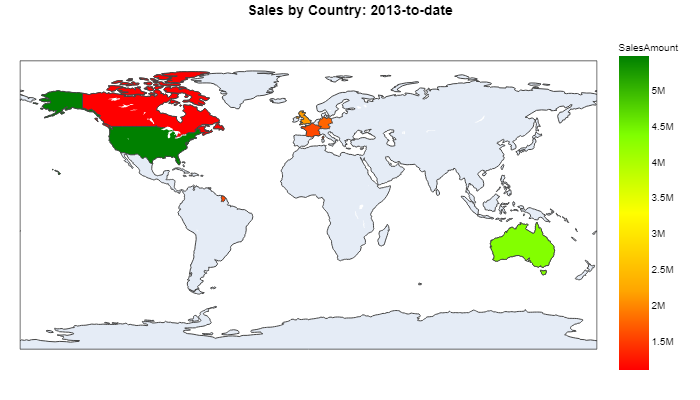

In [42]:
Image("map-dist.png")

**--INSIGHTS**
- from the chloropleth map above, we can see that the United States is the most profitable market (before shipping, taxes, et al) for Adventure Works, followed by Australia
- the European market and Canada are thye converse of this. This can be due to a myriad of factors like cycling popularity, competition, poor brand presence or the weather
- an opportunity exists in those regions. However, the analysis for that is outside the scope of this report 

> That marks the end of our analysis. However, we are not quite done yet. We still have to make this document digestible for a non-technical audience. That means removing all our Python (and SQL) code. How can we do that you might ask? Remember at the beginning we mentioned how Jupyter Notebooks are essentially built using HTML, CSS AND JavaScript? We can actually execute JS within the notebook itself, which is pretty cool. In this particular case, we are going to be using JavaScript to hide all the input cells within the notebook. Remember the input cells are the ones that contain our code. We will do this by using a toggle button. See the code below.

In [22]:
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="TOGGLE INPUT"></form>''')

> By running the cell above, we introduce a _Toggle_ button that allows us to hide/show all the input cells within this notebook. Go ahead and click it.
> Scroll up, and you will notice that all of our code cells have been hidden. The only content that remains is our outputs and markdown. Tricks like this are what makes the Jupyter Notebook my favorite analytics tool. Because we were carefully labelling our sections and annotating our results (the _INSIGHTS_), this document can be shared with stakeholders of any level as is. No need to export your visualization to a tool like Powepoint, nor your exploration logic to a Business Intelligence tool like Tableau/Power BI. Your entire analytics workflow AND presentation all in one place.
> And there you have it folks, **Jupyter Notebooks as an End-to-End Analytics Solution**. 😃